### Import Packages

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk import word_tokenize,ne_chunk,pos_tag,wordpunct_tokenize
import rake_nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from itertools import chain, groupby, product
from collections import defaultdict, Counter
import networkx as nx
from networkx.algorithms import community
from gensim.models import Word2Vec,KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.ldamodel import LdaModel
import gensim
import statsmodels.api as sm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
from scipy.stats import normaltest
% matplotlib notebook

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load Data

In [162]:
all_data_store_path = '/Users/tylio/Google Drive/2018 spring/686/Wiley Sponsered Project/Data'
current_data_folder_name = '(40000+)_by_year'
current_data_store_path = os.path.join(all_data_store_path,current_data_folder_name)
data = pd.read_csv(os.path.join(current_data_store_path,'wholeFile_with_wholeTopic_v2_2.csv'))
topic_map_trend = pd.read_csv(os.path.join(current_data_store_path,'topic_map_trend_v2_2.csv'))

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,6,7,10,40,48,50,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [163]:
emerging_topics = topic_map_trend[topic_map_trend['emerging']==1]
shrinking_topics = topic_map_trend[topic_map_trend['shrinking']==1]
neutral_topics = topic_map_trend[topic_map_trend['neutral']==1]

In [164]:
emerging_topic_list = emerging_topics['topic'].values
shrinking_topic_list = shrinking_topics['topic'].values
neutral_topic_list = neutral_topics['topic'].values

### Review Proportion Analysis

In [192]:
emerging_topic_list

array(['bone', 'silk fibroin', 'mesenchymal stem cell', 'biodegradation',
       'nanofibers', 'cellulose', 'regeneration', 'nanomedicine', 'silk',
       'silver', 'osteogenesis', 'growth factor', 'extracellular matrix',
       'cancer', 'tissue engineering', 'drug delivery', 'magnesium',
       'alginate', 'cell', 'regenerative medicine', 'drug release',
       'production', 'nanocomposite', 'microspheres', 'drug', 'review',
       'antibacterial', 'antimicrobial', 'hydrogel', 'mechanical',
       'nanoparticles', 'scaffold', 'tissue', 'bone regeneration',
       'differentiation', 'wound', 'stem cell', 'application',
       'biomedical application'], dtype=object)

In [168]:
shrinking_topic_list

array(['polyester', 'titanium', 'study', 'surface modification',
       'biocompatibility', 'wear', 'cell culture', 'protein adsorption',
       'adhesion', 'cell adhesion', 'film', 'hydroxyapatite',
       'ethylene oxide', 'bacterial adhesion', 'implant',
       'blood compatibility', 'surface', 'ceramic', 'osteoblast',
       'polymer', 'modification', 'biodegradable polymer', 'fibronectin',
       'adsorption', 'immobilization', 'interaction', 'ethylene glycol',
       'plasma', 'bioceramics', 'apatite', 'vitro'], dtype=object)

In [169]:
neutral_topic_list

array(['investigation', 'biofilm', 'self-assembly', 'gel',
       'mineralization', 'polyurethane', 'dna', 'bioactive glass',
       'sol-gel', 'mechanism', 'platelet adhesion', 'poly', 'r',
       'synthesis', 'magnesium alloy', 'hyaluronic acid', 'macrophage',
       'characterization', 'vivo', 'biodegradable', 'development',
       'hemocompatibility', 'corrosion', 'nanofiber', 'bioactivity',
       'fabrication', 'fibroblast', 'platelet', 'influence', 'processing',
       'antibacterial activity', 'growth', 'rabbit', 'nanostructures',
       'photopolymerization', 'structure', 'heparin', 'nanocomposites',
       'material', 'composite', 'interface', 'microstructure',
       'carbon nanotube', 'chitosan', 'tissue regeneration', 'evaluation',
       'angiogenesis', 'additive manufacturing', 'polysaccharide',
       'design', 'rat', 'metal', '3d printing', 'biomimetic', 'gelatin',
       'enzyme', 'epsilon-caprolactone', 'peptide', 'cartilage',
       'comparison', 'repair', 'bone tis

In [7]:
def DT_trend_over_time(topiclist,document_type):
    plt.figure(figsize = (10,6))
    for j in document_type:
        for i in topiclist:
            sample = data[data[i].notnull()]
            dt = sample.groupby('PY').agg({'DA':'count','DT': lambda x: (x.str.startswith(j)).sum()}).rename(columns = {'DT':j,'DA':'All'})
            dt.loc[:,'percentage'] = dt[j]/dt.All
            dt['percentage'].plot(label = i)
    ax = plt.gca()
    plt.ylim((0,0.5))
    ax.set_yticklabels(['{:3.0f}%'.format(i*100) for i in ax.get_yticks()])
    plt.xlim((2000,2017))
    plt.title('Review over Time Stage',fontsize = 15)
    plt.xlabel('Publication Year',fontsize = 15)
    plt.ylabel('Percentage among Document Type',fontsize = 15)
    plt.legend()
    plt.grid(axis = 'x')

<IPython.core.display.Javascript object>


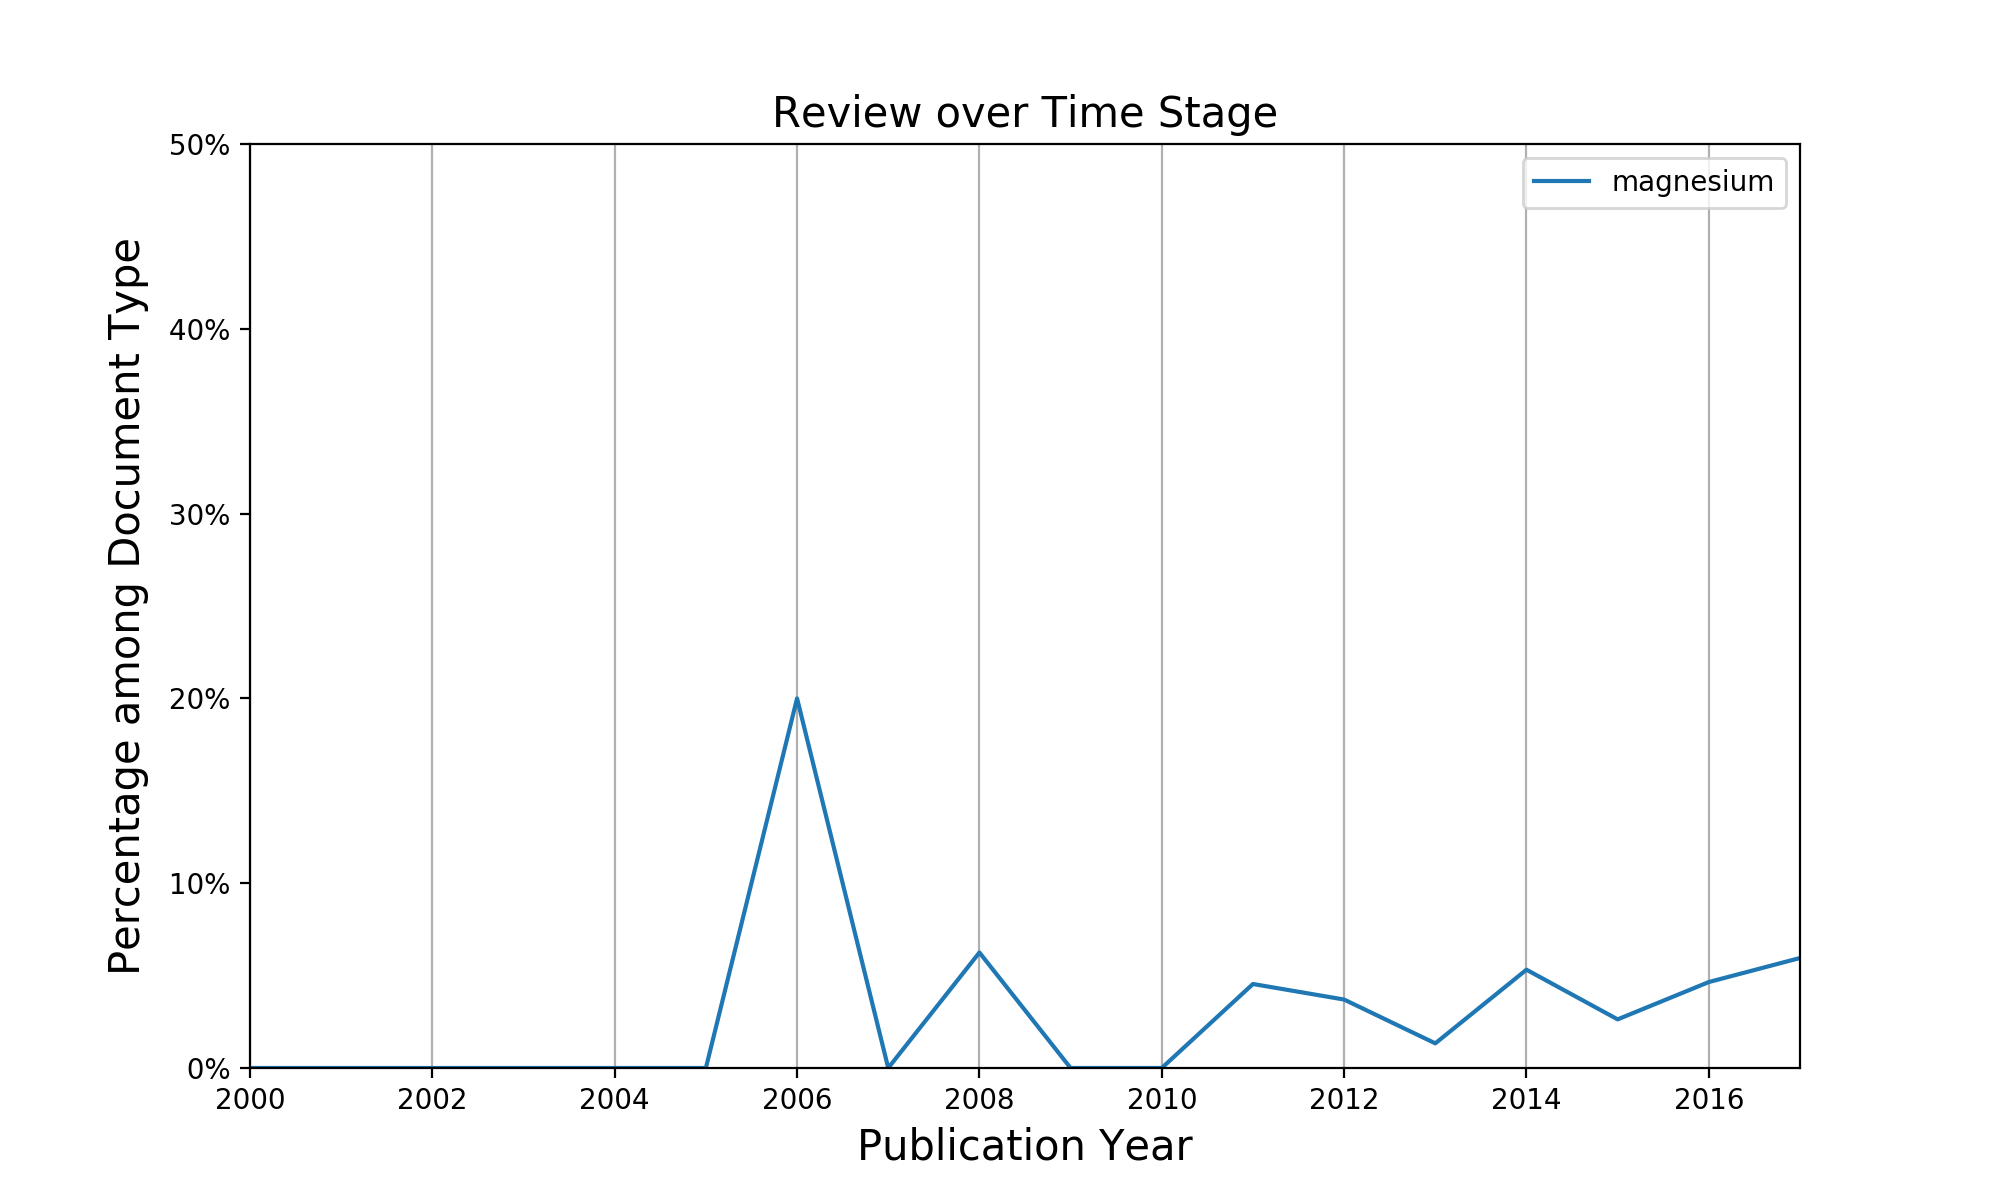

In [8]:
DT_trend_over_time(['magnesium'],['Review'])

In [27]:
data[(data['PY']==2002) & (data['DT']=='Review')]

,PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,...,fibroin,cellulose,adsorption,biomimetic,calorimetry,integrin,tissue engineering,reconstruction,nanoindentation,inflammation
7786,J,"Miyata, T; Uragami, T; Nakamae, K",NaN,NaN,NaN,"Miyata, T; Uragami, T; Nakamae, K",NaN,NaN,Biomolecule-sensitive hydrogels,ADVANCED DRUG DELIVERY REVIEWS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7796,J,"Lygre, H",NaN,NaN,NaN,"Lygre, H",NaN,NaN,Prosthodontic biomaterials and adverse reactio...,ACTA ODONTOLOGICA SCANDINAVICA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7806,J,"Forster, S; Plantenberg, T",NaN,NaN,NaN,"Forster, S; Plantenberg, T",NaN,NaN,From self-organizing polymers to nanohybrid an...,ANGEWANDTE CHEMIE-INTERNATIONAL EDITION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7807,J,"Dorozhkin, SV; Epple, M",NaN,NaN,NaN,"Dorozhkin, SV; Epple, M",NaN,NaN,Biological and medical significance of calcium...,ANGEWANDTE CHEMIE-INTERNATIONAL EDITION,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7846,J,"Hong, MC",NaN,NaN,NaN,"Hong, MC",NaN,NaN,Inorganic and organic hybride polymers: A new ...,CHINESE JOURNAL OF INORGANIC CHEMISTRY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7855,J,"Lindblad, MS; Liu, Y; Albertsson, AC; Ranucci,...",NaN,NaN,NaN,"Lindblad, MS; Liu, Y; Albertsson, AC; Ranucci,...",NaN,NaN,Polymers from renewable resources,DEGRADABLE ALIPHATIC POLYESTERS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7886,J,"Merrett, K; Cornelius, RM; McClung, WG; Unswor...",NaN,NaN,NaN,"Merrett, K; Cornelius, RM; McClung, WG; Unswor...",NaN,NaN,Surface analysis methods for characterizing po...,JOURNAL OF BIOMATERIALS SCIENCE-POLYMER EDITION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7918,J,"Ottani, V; Raspanti, M; Martini, D; Tretola, G...",NaN,NaN,NaN,"Ottani, V; Raspanti, M; Martini, D; Tretola, G...",NaN,NaN,Electromagnetic stimulation on the bone growth...,MICRON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7924,J,"Jenkins, CL; Raines, RT",NaN,NaN,NaN,"Jenkins, CL; Raines, RT",NaN,NaN,Insights on the conformational stability of co...,NATURAL PRODUCT REPORTS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7971,J,"Holmes, TC",NaN,NaN,NaN,"Holmes, TC",NaN,NaN,Novel peptide-based biomaterial scaffolds for ...,TRENDS IN BIOTECHNOLOGY,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [170]:
data_review_00_17 = data[(data['PY']>=2000)&(data['PY']<=2017)]
def getSingleReviewProportion(topic,df):
    sample = df[df[topic]==1]
    dt = sample.groupby('PY').agg({'DA':'count','DT': lambda x: (x.str.startswith('Review')).sum()}).rename(columns = {'DT':'review','DA':'All'})
    dt.loc[:,topic] = dt['review']/dt.All
    return dt[topic]

def getAllReviewProportion(topic_list,df):
    all_review = pd.DataFrame()
    for topic in topic_list:
        all_review = pd.concat([all_review,pd.DataFrame(getSingleReviewProportion(topic,df))],axis = 1)
    return list(all_review.mean())
        

In [135]:
emerging_review_pro = getAllReviewProportion(emerging_topic_list,data_review_00_17)

In [136]:
shrinking_review_pro = getAllReviewProportion(shrinking_topic_list,data_review_00_17)

In [171]:
neutral_review_pro = getAllReviewProportion(neutral_topic_list,data_review_00_17)

In [140]:
e1 = pd.DataFrame(emerging_review_pro,columns=['review proportion'])
e1['emergingOrShrinking'] = 'emerging'
s1 = pd.DataFrame(shrinking_review_pro,columns=['review proportion'])
s1['emergingOrShrinking'] = 'shrinking'
for_box_plots = pd.concat([e1,s1])

<IPython.core.display.Javascript object>


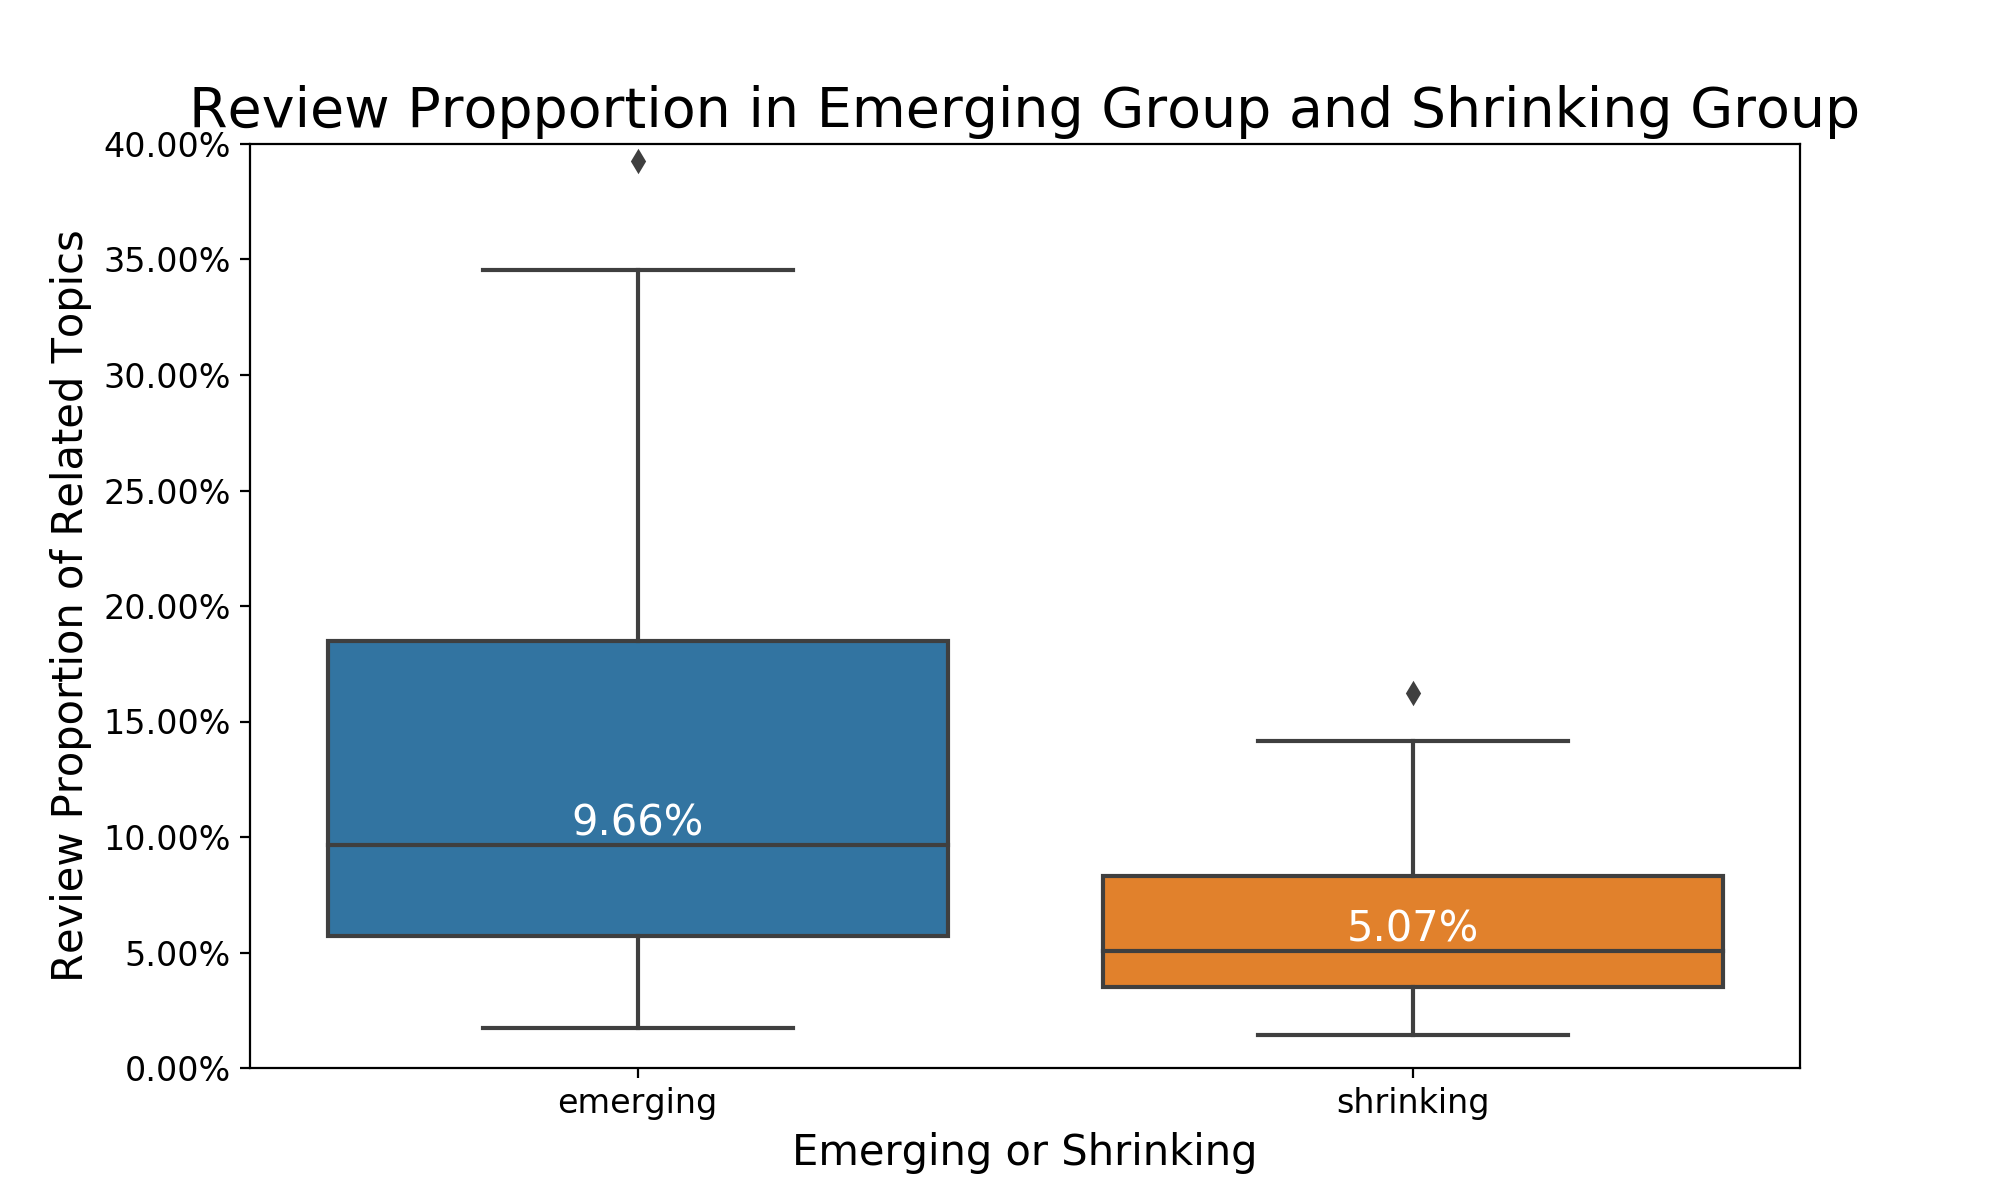

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


In [141]:
plt.figure(figsize = (10,6))
ax = sns.boxplot(x = 'emergingOrShrinking',y = 'review proportion',data = for_box_plots)#,order=['1972-2000', '2001-2005', '2006-2010', '2011-2015', '2016-2018'])
plt.grid('off')
#ax.set_ylim(0,20)
medians = for_box_plots.groupby('emergingOrShrinking')['review proportion'].median().values
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]
    text_label = medians[i]
    plt.text(x_co,y_co,'{:3.2f}%'.format(text_label*100).format(),ha = 'center',va = 'bottom',size = 15,color = 'white')
plt.xlabel('Emerging or Shrinking',fontsize = 15)
plt.ylabel('Review Proportion of Related Topics',fontsize = 15)
plt.ylim(0,0.4)
plt.xticks(fontsize=12)
ax.set_yticklabels(['{:3.2f}%'.format(i*100) for i in ax.get_yticks()])
plt.yticks(fontsize=12)
plt.title('Review Propportion in Emerging Group and Shrinking Group',fontsize = 20)

In [146]:
ttest_ind(emerging_review_pro,shrinking_review_pro,equal_var=False)[1]/2

0.0005525650973981121

In [186]:
def threshold_analysis(threshold):
    emerging_num = np.sum(np.array(emerging_review_pro)>=threshold)
    shrinking_num = np.sum(np.array(shrinking_review_pro)>=threshold)
    neutral_num = np.sum(np.array(neutral_review_pro)>=threshold)
    emerging_perc = emerging_num/(emerging_num+shrinking_num+neutral_num)
    shrinking_prec = shrinking_num/(emerging_num+shrinking_num+neutral_num)
    return emerging_num,emerging_perc,shrinking_num,shrinking_prec

In [190]:
threshold_analysis(0.15)

(13, 0.4642857142857143, 1, 0.03571428571428571)

In [17]:
def document_type_distribution(topic,year):
    sample = data[(data['PY']==year)&(data[topic].notnull())]
    return sample['DT'].value_counts()/sample['DT'].value_counts().sum()

In [121]:
def pie_plot_for_review_proportion(topic,year):
    fig1,ax1 = plt.subplots(figsize=(8, 4))
    import matplotlib.cm as cm
    import matplotlib as mpl
    num = 7
    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0.9, 0, num)]
    dt_distribution = document_type_distribution(topic,year)
    explode = [0,0.1]+[0 for i in range(len(dt_distribution)-2)]
    ax1.pie(dt_distribution,explode=explode,labels = dt_distribution.index,colors=colors,autopct='%1.1f%%',radius = 1,labeldistance=1.1,wedgeprops = {'linewidth': 10})
    ax1.axis('equal')
    #plt.title('Regeneration')
    plt.xlabel(year,fontsize = 15)
    plt.tight_layout()

<IPython.core.display.Javascript object>


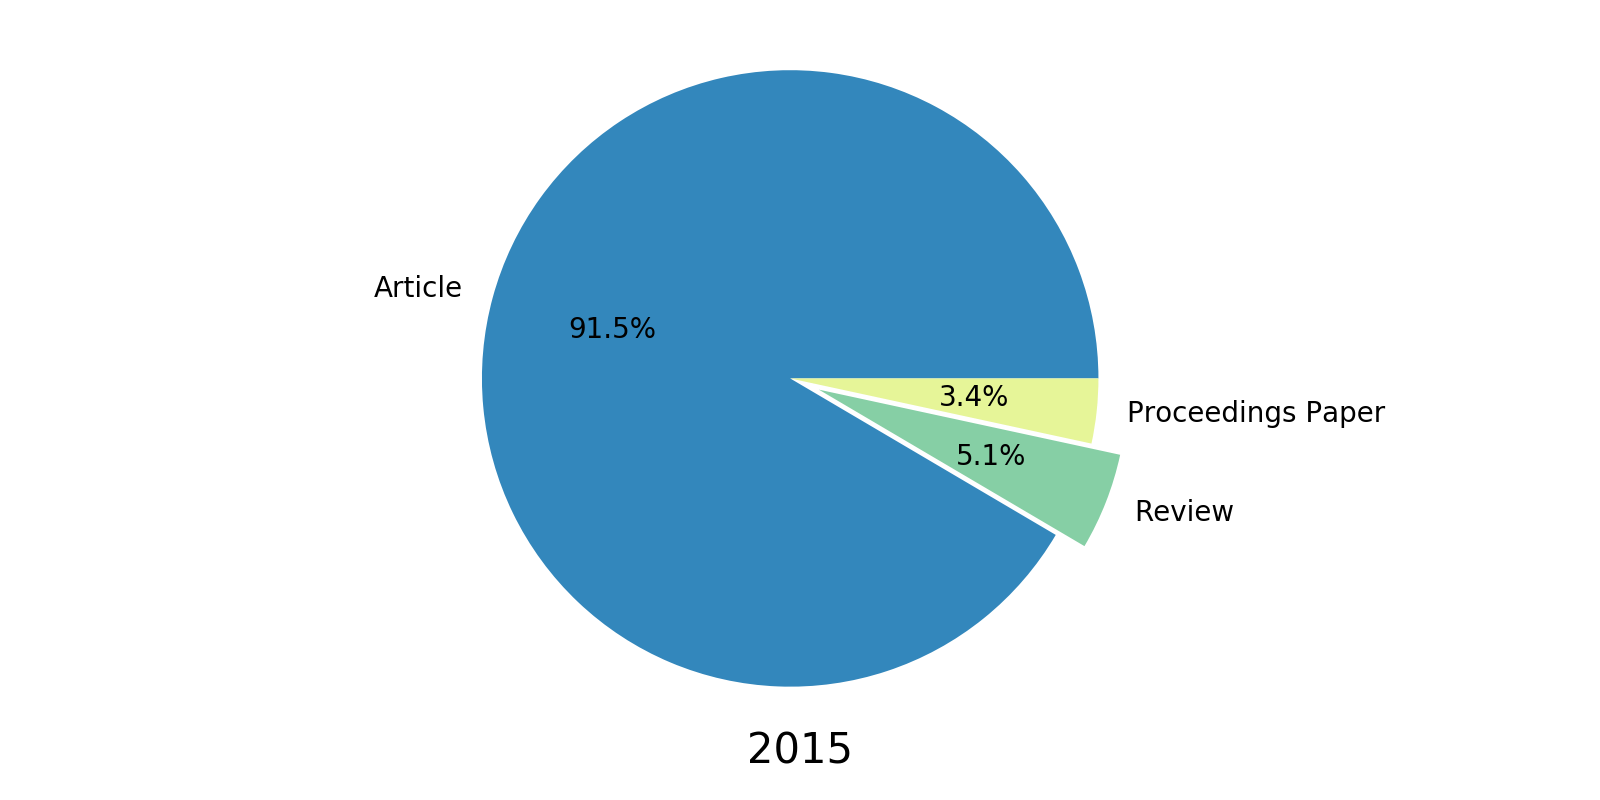

In [133]:
pie_plot_for_review_proportion('adhesion',2015)